# Sprint6課題 機械学習スクラッチ決定木

## この課題の目的
- スクラッチを通して決定木を理解する
- 複雑なアルゴリズムの実装に慣れる

## スクラッチによる実装

- NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。

- 決定木は分類と回帰双方に使用できますが、分類のみを扱います。

- 必須課題としては空間の分割を1回だけ行う、深さ1の決定木を作成します。それよりも深い決定木の作成はアドバンス課題とします。

###  クラスのインポート

- .pyファイルを修正したら、一度kernelをshutdownした後に呼び出すこと。

In [1]:
import sys

sys.path.append("/Users/makintosh/diveintocode-term1/ml-scratch")

from utils.ScratchDecisionTree import ScratchDecisionTreeClassifier
from utils.decision_region import decision_region

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

## 【問題1】ジニ不純度を求める関数

まずは空間を分割するための指標値、ジニ不純度を計算する関数を作成してください。ノード$t$に対するジニ不純度$I(t)$は以下の数式で求まります。

$I(t) = 1-\sum_{i=1}^{K}P^2(C_i|t) = 1-\sum_{i=1}^{K}(\frac{N_{t,i}}{N_{t,all}})^{2}$


$t$ : ノードのインデックス

$i$ : クラスのインデックス

$K$ : クラスの数

$C_i$ : i番目のクラス

$P(C_i|t)$ :　t番目のノードにおけるC_iの割合

$N_{t,i}$ : t番目のノードのi番目のクラスに属するサンプル数

$N_{t,all}$ : t番目のノードのサンプルの総数

In [3]:
def impurity(self, y):
    """
    ジニ不純度を求める
    
    Parameters
    ----------
    y : 次の形のndarray, shape(m_samples)
        正解値

    Returns
    ----------
    impurity : float
        ジニ不純度

    """
    # 目的変数の値、及び要素数を取得する
    class_value, class_count = np.unique(y, return_counts = True)

    # ジニ不純度を算出する
    if len(y) > 0:
        impurity = 1 - np.sum(np.square(class_count / len(y)))
    elif len(y) == 0:
        impurity = 0
        
    return impurity

## 【問題2】情報利得を求める関数

次に、情報利得を計算する関数を作成してください。先ほど作成したジニ不純度 
$I(t)$を計算する関数を呼び出して使います。情報利得$IG$は以下の数式で求まります。

$IG(p) = I(p)-\frac{N_{left,all}}{N_{p,all}}I(left)-\frac{N_{right,all}}{N_{p,all}}I(right)$


$p$ : 親ノードを示すインデックス

$left$ : 左側のノードを示すインデックス

$right$ : 右側のノードを示すインデックス

In [4]:
def information_gain(self, y, left_index, right_index):
        """
        情報利得を求める

        Parameters
        ----------
        y : 次の形のndarray, shape(m_samples,)
            学習用データの正解値

        left_index : list
            特徴量が閾値以上のサンプルのインデックス

        rifht_index : list
            特徴量が閾値未満のサンプルのインデックス

        Returns
        ----------
        info_gain : float
            情報利得

        """

        # ジニ不純度
        self.impurity = self.impurity(y) # 親ノードのジニ不純度
        impurity_left = self.impurity(y_train[left_index]) # 閾値以上で分割されたクラス
        impurity_right = self.impurity(y_train[right_index]) # 閾値未満で分割されたクラス

        # 要素数
        count_parent = len(y_train) # 親ノードの要素数
        count_left = len(left_index[0]) # 閾値以上で分割されたクラスの要素数
        count_right = len(right_index[0]) # 閾値未満で分割されたクラスの要素数

        # 情報利得を求める
        info_gain = self.impurity - (count_left / count_parent) * impurity_left - (count_right / count_parent) * impurity_right

        return info_gain

### データセットの準備

- 以降、2値分類にはirisのデータセットを用いる。

In [5]:
from sklearn.datasets import load_iris

In [6]:
# データ作成
iris = load_iris()

df = pd.DataFrame(iris.data, columns = iris.feature_names)
df["target"] = iris.target

data = df[df["target"] != 2]

In [7]:
# 2値分類を行うためのデータセット（X:説明変数、y:目的変数）
X= data.drop(["petal length (cm)","petal width (cm)", "target"], axis = 1).values
y = data["target"].values

In [8]:
# validation
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10)

## 【問題3】深さ1の決定木分類器クラスの作成

深さが1の決定機分類器のクラスを作成し、Sprint2で作成した分類のパイプラインに組み込んでください。

クラスの基本構造はSprint3の線形回帰を参考にし、名前はScratchDecesionTreeClassifierとしてください。

メソッドやパラメータなどはscikit-learnを参考にしてください。

検証段階ではJupyter Notebook上で書いていき、最終的にはpyファイルにモジュールとしてまとめてください。

深さ1とは空間の分割を1回だけ行うことを指します。

[決定木のアルゴリズム]

ある特徴量の軸に対して、全てのパターンのしきい値を考え、それぞれの情報利得を計算していきます。各点の値をしきい値にする方法が一般的です。（ただし、実際にはしきい値の数は点の数よりひとつ少なくて良いことになります）分割の全候補の中で最も情報利得が大きくなるものをそのノードの分割方法として採用します。

ジニ不純度が0になるノード、または指定された深さのノードは葉と呼ばれます。葉にはそれぞれ推定時にどのクラスに分類するかを記録しておきます。ジニ不純度が0でない場合は、多数決により分類するクラスを決定します。

In [9]:
# インスタンス生成
clf1 = ScratchDecisionTreeClassifier(max_depth = 1)

In [10]:
# 学習
clf1.fit(X_train, y_train)

In [11]:
# 予測
y_pred1 = clf1.predict(X_test)

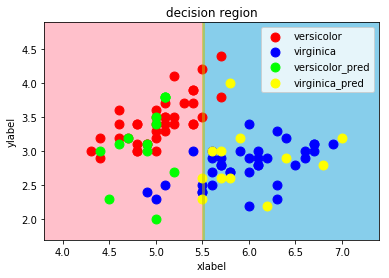

In [12]:
# 1階層の決定木による分類結果を可視化
decision_region(X_train, y_train, clf1, X_test=X_test, y_pred=y_pred1)

- 1階層では、分類しきれない。

- 決定木の境界線は、縦・横に方向が限定される。（斜めに境界線を引くことができるならば、１回で分類できそうだが）

## 【問題4】（アドバンス課題）深さ2の決定木分類器クラスの作成

問題3で作成したクラスを発展させ、深さが2の決定木分類器のクラスを作成してください。

深さ2とは空間の分割を2回行うことを指します。

In [13]:
## インスタンス生成
clf２ = ScratchDecisionTreeClassifier(max_depth = 2)

In [14]:
# 学習
clf2.fit(X_train, y_train)

In [15]:
# 予測
y_pred2 = clf2.predict(X_test)

df_pred2 = pd.DataFrame(y_pred2, columns = ["y_pred"])
df_pred2["y_true"] = y_test
df_pred2

,y_pred,y_true
0,0,0
1,0,0
2,0,0
3,0,0
4,1,1
5,0,0
6,1,1
7,1,0
8,0,0
9,1,1


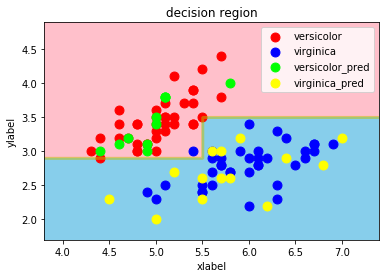

In [16]:
# 1階層の決定木による分類結果を可視化
decision_region(X_train, y_train, clf2, X_test=X_test, y_pred=y_pred2)

- 決定木の深さは２階層でも、概ね正確に分類できる。

## 【問題5】（アドバンス課題）任意の深さに対応できる決定木分類器クラスの作成

問題3,4で作成したクラスを発展させ、任意の深さに対応できる決定木分類器のクラスを作成してください。深さを特定の値で指定せず、全ての葉がジニ不純度0となるまで続けられるようにしてください。

In [17]:
# max_depthを設定しない
clf = ScratchDecisionTreeClassifier()

In [18]:
# 学習
clf.fit(X_train, y_train)

In [19]:
##予測
y_pred3 = clf.predict(X_test)

df_pred3 = pd.DataFrame(y_pred3, columns = ["y_pred"])
df_pred3["y_true"] = y_test
df_pred3

,y_pred,y_true
0,0,0
1,0,0
2,0,0
3,0,0
4,1,1
5,0,0
6,1,1
7,1,0
8,0,0
9,1,1


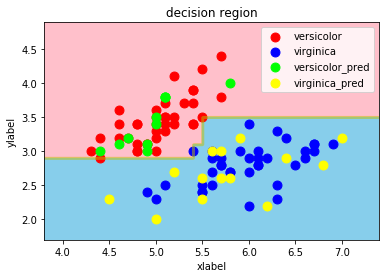

In [20]:
# 決定木による分類結果を可視化
decision_region(X_train, y_train, clf, X_test=X_test, y_pred=y_pred3)

- virginicaの決定領域（中心）が僅かながら拡大している。

# 【問題6】指標値の算出

- 分類に関する指標値で精度を確認してください。

In [21]:
accuracy = accuracy_score(y_test, y_pred2)
precision = precision_score(y_test, y_pred2)
recall = recall_score(y_test, y_pred2)
f1 = f1_score(y_test, y_pred2)
auc = roc_auc_score(y_test, y_pred2)

print("accuracy : {}".format(accuracy))
print("precision : {}".format(precision))
print("recall : {}".format(recall))
print("f1 : {}".format(f1))
print("auc : {}".format(auc))

accuracy : 0.96
precision : 0.9285714285714286
recall : 1.0
f1 : 0.962962962962963
auc : 0.9583333333333333


# 【問題7】決定領域の可視化

- 2値分類のデータセットに対して決定領域を可視化してください。

- **課題３〜５で可視化済のため省略する。**

# 【問題8】決定木の利用場面

- 最終発表時に以下の内容についてディスカッションを行います。自分なりの意見を用意しておいてください。

- 決定木が他の手法に比べて有効だと考えられるのはどういった場面か。

1. 決定木による分類の本質は、特徴量の比較を繰り返しであり、他の機械学習の手法に比べて分類過程を理解しやすい。


2. 留意点としては、以下が挙げられる。

    - **overfitting**：データセットに外れ値が含まれている場合、決定木の階層が深すぎると外れ値付近で微細に決定領域を作ってしまい、汎化性能が損なわれる可能性がある。学習結果の可視化、評価結果のスコアリング等を通じて、ハイパーパラメータ（ジニ不純度、深度など）の調整が必要。
 
    - **学習効率** : サンプル数が多い場合、学習時における情報利得の計算に時間を要する。例えば、特徴量をカテゴリ分け（ヒストグラム化）した上で、カテゴリの境界線を分類の閾値として用いる等の工夫の余地があると考えられる。

# 本課題からの学び

- 本課題からの最も重要な学びは、クラス、関数の再帰的利用の有用性にある。クラスの中でクラスを呼び出す、関数内で関数を呼び出すことで、最小単位（決定木で言えば１つのノード）をコード化すれば良く、コードをシンプルにできると分かった。


- 関数の再帰的利用（定義している関数f内で関数fを呼び出す）を通じて、本当の意味で関数の"return"を理解できた気がする。最終的に得られた結果（決定木で言えば最も深い層の判定結果）を、関数の呼び出し元（親ノード）に対して返し続けるということだと分かった。


- データ型に注意すること。： 
    np.whereは、array形式でindexを出力する。但し、arrayがtupleに格納されており、len()でindexの個数をカウントしたら1が返ってきてしまい、情報利得が正しく計算されなかった。len(index[0])とすることで個数を正確にカウントすることができた。今後は、メソッドの出力について、データ型のみならず、要素に対して正確にアクセスできるように都度サンプルを用いて確認するようにしたい。

### 有用な関数

- [np.unique](https://docs.scipy.org/doc/numpy/reference/generated/numpy.unique.html)